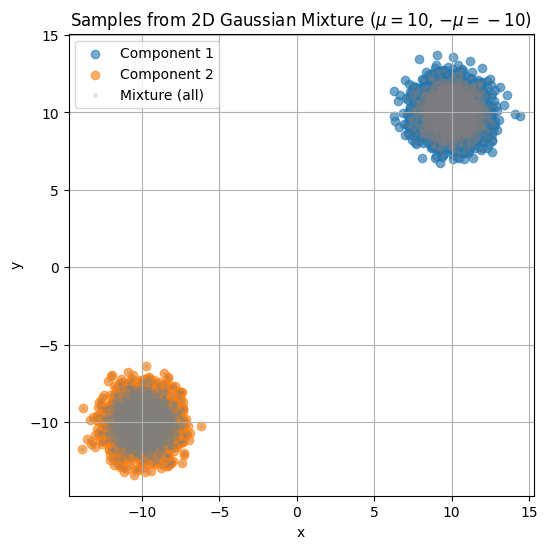

In [67]:
import torch
import matplotlib.pyplot as plt

# Set the mean value for mixture components
mu = 10

# Number of samples per component
n_samples = 5000

# Means for two components in 2D
means = torch.tensor([[mu, mu], [-mu, -mu]], dtype=torch.float)

# Covariance (identity for both)
cov = torch.eye(2)

# Sample standard normal, then shift by mean
def sample_gaussian(mean, cov, n):
    return torch.randn(n, 2) @ cov.sqrt() + mean

# Generate samples for each component
samples_1 = sample_gaussian(means[0], cov, n_samples)
samples_2 = sample_gaussian(means[1], cov, n_samples)

# Stack together
mixture_samples = torch.cat([samples_1, samples_2], dim=0)

# Visualize the samples
plt.figure(figsize=(6, 6))
plt.scatter(samples_1[:, 0], samples_1[:, 1], alpha=0.6, label='Component 1')
plt.scatter(samples_2[:, 0], samples_2[:, 1], alpha=0.6, label='Component 2')
plt.scatter(mixture_samples[:, 0], mixture_samples[:, 1], s=5, color='gray', alpha=0.2, label='Mixture (all)')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Samples from 2D Gaussian Mixture ($\mu={}$, $-\mu={}$)'.format(mu, -mu))
plt.legend()
plt.axis('equal')
plt.grid(True)
plt.show()




Total samples: 10000
Batch size: 256
Batches per epoch: 40
Total training steps: 12000


Epoch 1/300 | Average Loss: 94.0329


Epoch 11/300 | Average Loss: 61.1849


Epoch 21/300 | Average Loss: 38.1452


Epoch 31/300 | Average Loss: 22.0980


Epoch 41/300 | Average Loss: 12.0835


Epoch 51/300 | Average Loss: 6.3508


Epoch 61/300 | Average Loss: 3.2681


Epoch 71/300 | Average Loss: 1.9543


Epoch 81/300 | Average Loss: 1.4844


Epoch 91/300 | Average Loss: 1.3406


Epoch 101/300 | Average Loss: 1.3114


Epoch 111/300 | Average Loss: 1.3033


Epoch 121/300 | Average Loss: 1.3016


Epoch 131/300 | Average Loss: 1.3208


Epoch 141/300 | Average Loss: 1.3157


Epoch 151/300 | Average Loss: 1.2821


Epoch 161/300 | Average Loss: 1.2986


Epoch 171/300 | Average Loss: 1.3146


Epoch 181/300 | Average Loss: 1.3015


Epoch 191/300 | Average Loss: 1.3083


Epoch 201/300 | Average Loss: 1.3106


Epoch 211/300 | Average Loss: 1.3243


Epoch 221/300 | Average Loss: 1.2998


Epoch 231/300 | Average Loss: 1.3260


Epoch 241/300 | Average Loss: 1.3154


Epoch 251/300 | Average Loss: 1.3436


Epoch 261/300 | Average Loss: 1.2953


Epoch 271/300 | Average Loss: 1.3061


Epoch 281/300 | Average Loss: 1.3139


Epoch 291/300 | Average Loss: 1.3278


Epoch 300/300 | Average Loss: 1.3155


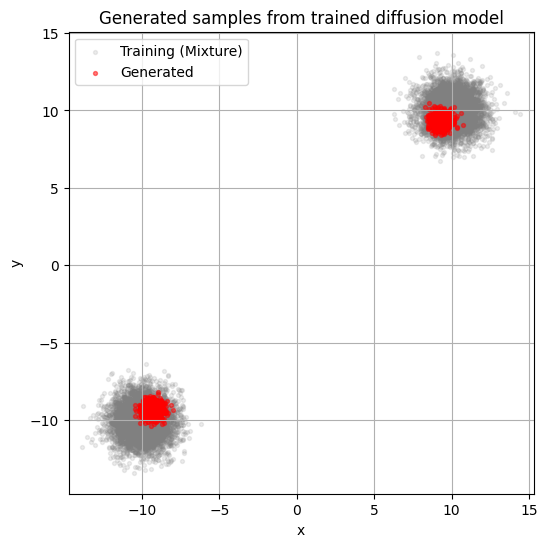

In [74]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data and configs
data = mixture_samples.to(device)
n, d = data.shape
T = 100  # Number of diffusion steps

# Define the two-layer model with Sharp Sigmoid activation
class TwoLayerDiffusionModel(nn.Module):
    def __init__(self, d, sigmoid_sharpness=10.0):
        super().__init__()
        self.linear1 = nn.Linear(d, 1, bias=False)
        self.sigmoid = nn.Sigmoid()
        self.linear2 = nn.Linear(1, d, bias=True)  # Added bias
        self.sharpness = sigmoid_sharpness  # Controls sigmoid steepness

    def forward(self, x):
        out = self.linear1(x)
        out = self.sigmoid(self.sharpness * out)  # Sharp sigmoid
        out = self.linear2(out)
        return out

model = TwoLayerDiffusionModel(d).to(device)

# Diffusion (DDPM-style) parameters
beta_start = 1e-4
beta_end = 0.02
betas = torch.linspace(beta_start, beta_end, T).to(device)
alphas = 1. - betas
alpha_bars = torch.cumprod(alphas, dim=0)

# Loss: predict the added noise
optimizer = optim.Adam(model.parameters(), lr=1e-2)

# Training configuration
epochs = 300  # number of passes through the entire dataset
batch_size = 256

# Create DataLoader for proper batching
dataset = TensorDataset(data)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

print(f"Total samples: {n}")
print(f"Batch size: {batch_size}")
print(f"Batches per epoch: {len(dataloader)}")
print(f"Total training steps: {epochs * len(dataloader)}")

for epoch in range(epochs):
    epoch_loss = 0.0
    num_batches = 0
    
    for (x0_batch,) in tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}", leave=False):
        x0 = x0_batch.to(device)  # [batch_size, d]
        current_batch_size = x0.shape[0]
        
        # Sample random timesteps for this batch
        t = torch.randint(0, T, (current_batch_size,), device=device).long()
        noise = torch.randn_like(x0)

        alpha_bar_t = alpha_bars[t].view(-1, 1)
        xt = (alpha_bar_t.sqrt()) * x0 + (1 - alpha_bar_t).sqrt() * noise

        pred_noise = xt/alpha_bar_t.sqrt() - model(xt)
        loss = ((pred_noise - noise) ** 2).mean()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        num_batches += 1
    
    avg_loss = epoch_loss / num_batches
    if epoch % 10 == 0 or epoch == epochs - 1:
        print(f"Epoch {epoch+1}/{epochs} | Average Loss: {avg_loss:.4f}")

# Generation function (DDPM sampling)
@torch.no_grad()
def sample_ddpm(model, n_samples, d, T):
    x = torch.randn(n_samples, d).to(device)
    for t in reversed(range(T)):
        beta_t = betas[t]
        alpha_t = alphas[t]
        alpha_bar_t = alpha_bars[t]
        # Model predicts x0 (clean sample), convert to noise prediction
        pred_x0 = model(x)
        pred_noise = x / alpha_bar_t.sqrt() - pred_x0
        coef_one = 1 / alpha_t.sqrt()
        coef_two = (1 - alpha_t) / (1 - alpha_bar_t).sqrt()
        # Update
        x = coef_one * (x - coef_two * pred_noise)
        if t > 0:
            noise = torch.randn_like(x)
            x = x + beta_t.sqrt() * noise  # add stochasticity for t > 0
    return x.cpu()

# Generate samples
gen_samples = sample_ddpm(model, 1000, d, T)

# Visualization
plt.figure(figsize=(6,6))
plt.scatter(data[:,0].cpu(), data[:,1].cpu(), alpha=0.15, label='Training (Mixture)', color='gray', s=8)
plt.scatter(gen_samples[:,0], gen_samples[:,1], alpha=0.5, label='Generated', color='red', s=8)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Generated samples from trained diffusion model')
plt.legend()
plt.axis('equal')
plt.grid(True)
plt.show()



In [75]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data and configs
data = mixture_samples.to(device)
n, d = data.shape
T = 1000  # Number of diffusion steps

# Define the two-layer model with custom initialization and Sharp Sigmoid activation
class TwoLayerDiffusionModel(nn.Module):
    def __init__(self, d, init_direction=None, sigmoid_sharpness=10.0):
        super().__init__()
        self.linear1 = nn.Linear(d, 1, bias=False)
        self.sigmoid = nn.Sigmoid()
        self.linear2 = nn.Linear(1, d, bias=True)  # Added bias
        self.sharpness = sigmoid_sharpness  # Controls sigmoid steepness
        
        # Initialize with direction if provided
        if init_direction is not None:
            with torch.no_grad():
                # linear1.weight shape: (1, d) - project d-dimensional input to 1D
                # Initialize as normalized direction (unit vector)
                self.linear1.weight.copy_(init_direction.view(1, -1))
                
                # linear2.weight shape: (d, 1) - project 1D back to d dimensions
                # Initialize as normalized direction transposed
                self.linear2.weight.copy_(init_direction.view(-1, 1))
                self.linear2.bias.zero_()
                
                print(f"Initialized linear layers with direction: {init_direction}")
                print(f"||init_direction||: {init_direction.norm().item():.4f}")

    def forward(self, x):
        out = self.linear1(x)
        out = self.sigmoid(self.sharpness * out)  # Sharp sigmoid
        out = self.linear2(out)
        return out

# Compute μ/||μ|| from the first mixture component mean
mu_vector = means[0]  # [mu, mu] in 2D
mu_normalized = mu_vector / mu_vector.norm()
print(f"Original μ: {mu_vector}")
print(f"Normalized μ/||μ||: {mu_normalized}")

# Create model with normalized mu initialization
model = TwoLayerDiffusionModel(d, init_direction=mu_normalized).to(device)

# Diffusion (DDPM-style) parameters
beta_start = 1e-4
beta_end = 0.02
betas = torch.linspace(beta_start, beta_end, T).to(device)
alphas = 1. - betas
alpha_bars = torch.cumprod(alphas, dim=0)

# Loss: predict the added noise
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training configuration
epochs = 100  # number of passes through the entire dataset
batch_size = 256

# Create DataLoader for proper batching
dataset = TensorDataset(data)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

print(f"\nTotal samples: {n}")
print(f"Batch size: {batch_size}")
print(f"Batches per epoch: {len(dataloader)}")
print(f"Total training steps: {epochs * len(dataloader)}\n")

for epoch in range(epochs):
    epoch_loss = 0.0
    num_batches = 0
    
    for (x0_batch,) in tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}", leave=False):
        x0 = x0_batch.to(device)  # [batch_size, d]
        current_batch_size = x0.shape[0]
        
        # Sample random timesteps for this batch
        t = torch.randint(0, T, (current_batch_size,), device=device).long()
        noise = torch.randn_like(x0)

        alpha_bar_t = alpha_bars[t].view(-1, 1)
        xt = (alpha_bar_t.sqrt()) * x0 + (1 - alpha_bar_t).sqrt() * noise

        pred_noise = xt/alpha_bar_t.sqrt() - model(xt)
        loss = ((pred_noise - noise) ** 2).mean()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        num_batches += 1
    
    avg_loss = epoch_loss / num_batches
    if epoch % 10 == 0 or epoch == epochs - 1:
        print(f"Epoch {epoch+1}/{epochs} | Average Loss: {avg_loss:.4f}")

# Generation function (DDPM sampling)
@torch.no_grad()
def sample_ddpm(model, n_samples, d, T):
    x = torch.randn(n_samples, d).to(device)
    for t in reversed(range(T)):
        beta_t = betas[t]
        alpha_t = alphas[t]
        alpha_bar_t = alpha_bars[t]
        # Model predicts x0 (clean sample), convert to noise prediction
        pred_x0 = model(x)
        pred_noise = x / alpha_bar_t.sqrt() - pred_x0
        coef_one = 1 / alpha_t.sqrt()
        coef_two = (1 - alpha_t) / (1 - alpha_bar_t).sqrt()
        # Update
        x = coef_one * (x - coef_two * pred_noise)
        if t > 0:
            noise = torch.randn_like(x)
            x = x + beta_t.sqrt() * noise  # add stochasticity for t > 0
    return x.cpu()

# Generate samples
gen_samples = sample_ddpm(model, 1000, d, T)

# Visualization
plt.figure(figsize=(6,6))
plt.scatter(gen_samples[:,0], gen_samples[:,1], alpha=0.5, label='Generated', color='red', s=8)
plt.scatter(data[:,0].cpu(), data[:,1].cpu(), alpha=0.15, label='Training (Mixture)', color='gray', s=8)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Generated samples from trained diffusion model\n(Initialized with μ/||μ||)')
plt.legend()
plt.axis('equal')
plt.grid(True)
plt.show()



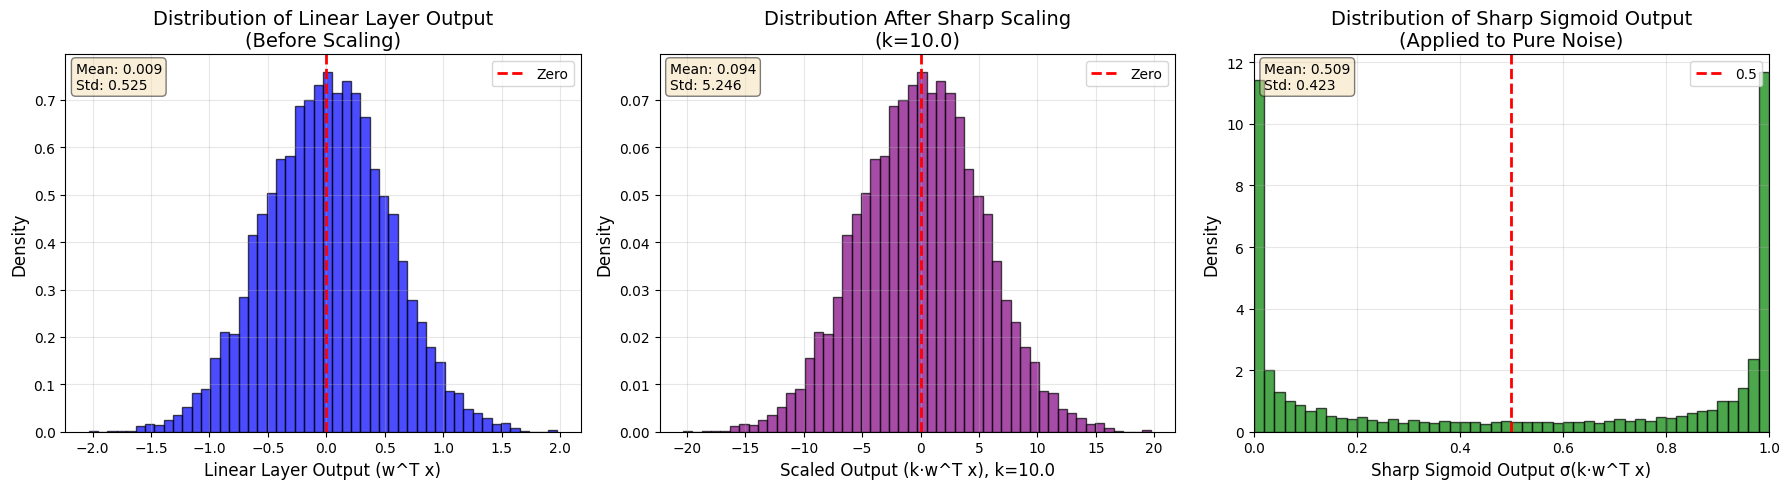


Statistics for 10000 pure noise samples:

Linear Layer Output (w^T x):
  Mean: 0.0094
  Std:  0.5246
  Min:  -2.0333
  Max:  1.9756

Scaled Output (k·w^T x) with k=10.0:
  Mean: 0.0945
  Std:  5.2459
  Min:  -20.3326
  Max:  19.7561

Sharp Sigmoid Output σ(k·w^T x):
  Mean: 0.5089
  Std:  0.4230
  Min:  0.0000
  Max:  1.0000

Learned Weights and Biases:

Linear1 (w from input layer):
  w1: [0.38507324 0.3642864 ]
  ||w1||: 0.5301
  Direction: [0.72644216 0.68722767]

Linear2 (w from output layer):
  w2: [19.968313 20.055927]
  ||w2||: 28.3015
  Direction: [0.7055572 0.708653 ]

Linear2 Bias (b2):
  b2: [-10.028688 -10.006893]
  ||b2||: 14.1673

Sigmoid Sharpness Parameter:
  k: 10.0



In [76]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Generate pure noise samples
n_noise_samples = 10000
pure_noise = torch.randn(n_noise_samples, d).to(device)

# Apply the model to get sigmoid activations
with torch.no_grad():
    # Get the output of the first linear layer
    linear1_output = model.linear1(pure_noise)  # Shape: (n_noise_samples, 1)
    
    # Apply sharp sigmoid activation
    sigmoid_output = model.sigmoid(model.sharpness * linear1_output)  # Shape: (n_noise_samples, 1)
    
    # Convert to numpy for plotting
    sigmoid_values = sigmoid_output.cpu().numpy().flatten()
    linear1_values = linear1_output.cpu().numpy().flatten()
    scaled_linear1_values = (model.sharpness * linear1_output).cpu().numpy().flatten()

# Create figure with three subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Histogram of linear layer output (before scaling)
axes[0].hist(linear1_values, bins=50, alpha=0.7, color='blue', edgecolor='black', density=True)
axes[0].set_xlabel('Linear Layer Output (w^T x)', fontsize=12)
axes[0].set_ylabel('Density', fontsize=12)
axes[0].set_title('Distribution of Linear Layer Output\n(Before Scaling)', fontsize=14)
axes[0].grid(True, alpha=0.3)
axes[0].axvline(0, color='red', linestyle='--', linewidth=2, label='Zero')
axes[0].legend()

mean_linear = linear1_values.mean()
std_linear = linear1_values.std()
axes[0].text(0.02, 0.98, f'Mean: {mean_linear:.3f}\nStd: {std_linear:.3f}', 
             transform=axes[0].transAxes, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Plot 2: Histogram of scaled linear output (after sharp scaling)
axes[1].hist(scaled_linear1_values, bins=50, alpha=0.7, color='purple', edgecolor='black', density=True)
axes[1].set_xlabel(f'Scaled Output (k·w^T x), k={model.sharpness}', fontsize=12)
axes[1].set_ylabel('Density', fontsize=12)
axes[1].set_title(f'Distribution After Sharp Scaling\n(k={model.sharpness})', fontsize=14)
axes[1].grid(True, alpha=0.3)
axes[1].axvline(0, color='red', linestyle='--', linewidth=2, label='Zero')
axes[1].legend()

mean_scaled = scaled_linear1_values.mean()
std_scaled = scaled_linear1_values.std()
axes[1].text(0.02, 0.98, f'Mean: {mean_scaled:.3f}\nStd: {std_scaled:.3f}', 
             transform=axes[1].transAxes, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Plot 3: Histogram of sigmoid output
axes[2].hist(sigmoid_values, bins=50, alpha=0.7, color='green', edgecolor='black', density=True)
axes[2].set_xlabel('Sharp Sigmoid Output σ(k·w^T x)', fontsize=12)
axes[2].set_ylabel('Density', fontsize=12)
axes[2].set_title(f'Distribution of Sharp Sigmoid Output\n(Applied to Pure Noise)', fontsize=14)
axes[2].grid(True, alpha=0.3)
axes[2].axvline(0.5, color='red', linestyle='--', linewidth=2, label='0.5')
axes[2].legend()
axes[2].set_xlim([0, 1])

mean_sigmoid = sigmoid_values.mean()
std_sigmoid = sigmoid_values.std()
axes[2].text(0.02, 0.98, f'Mean: {mean_sigmoid:.3f}\nStd: {std_sigmoid:.3f}', 
             transform=axes[2].transAxes, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

# Print detailed statistics
print(f"\n{'='*70}")
print(f"Statistics for {n_noise_samples} pure noise samples:")
print(f"{'='*70}")
print(f"\nLinear Layer Output (w^T x):")
print(f"  Mean: {mean_linear:.4f}")
print(f"  Std:  {std_linear:.4f}")
print(f"  Min:  {linear1_values.min():.4f}")
print(f"  Max:  {linear1_values.max():.4f}")
print(f"\nScaled Output (k·w^T x) with k={model.sharpness}:")
print(f"  Mean: {mean_scaled:.4f}")
print(f"  Std:  {std_scaled:.4f}")
print(f"  Min:  {scaled_linear1_values.min():.4f}")
print(f"  Max:  {scaled_linear1_values.max():.4f}")
print(f"\nSharp Sigmoid Output σ(k·w^T x):")
print(f"  Mean: {mean_sigmoid:.4f}")
print(f"  Std:  {std_sigmoid:.4f}")
print(f"  Min:  {sigmoid_values.min():.4f}")
print(f"  Max:  {sigmoid_values.max():.4f}")

# Analyze the learned weights
with torch.no_grad():
    w1 = model.linear1.weight.cpu().numpy().flatten()
    w1_norm = np.linalg.norm(w1)
    
    w2 = model.linear2.weight.cpu().numpy().flatten()
    w2_norm = np.linalg.norm(w2)
    
    b2 = model.linear2.bias.cpu().numpy().flatten()
    
print(f"\n{'='*70}")
print(f"Learned Weights and Biases:")
print(f"{'='*70}")
print(f"\nLinear1 (w from input layer):")
print(f"  w1: {w1}")
print(f"  ||w1||: {w1_norm:.4f}")
print(f"  Direction: {w1 / (w1_norm + 1e-12)}")
print(f"\nLinear2 (w from output layer):")
print(f"  w2: {w2}")
print(f"  ||w2||: {w2_norm:.4f}")
print(f"  Direction: {w2 / (w2_norm + 1e-12)}")
print(f"\nLinear2 Bias (b2):")
print(f"  b2: {b2}")
print(f"  ||b2||: {np.linalg.norm(b2):.4f}")
print(f"\nSigmoid Sharpness Parameter:")
print(f"  k: {model.sharpness}")
print(f"{'='*70}\n")



In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# ============================
# Configuration Parameters
# ============================
N = 10  # Number of mixture distributions to generate (S_0, S_1, ..., S_N)
n_samples_per_component = 500  # Number of samples per mixture component

# Define the base mean μ_0 and direction vector u
mu_0 = means[0]  # Starting mean (from first component: [mu, mu])
u = torch.tensor([-1.0, -1.0])  # Direction vector for gradual change

# Use the same covariance as the first distribution
cov_matrix = cov  # Identity covariance

print(f"Base mean μ_0: {mu_0}")
print(f"Direction vector u: {u}")
print(f"Covariance matrix:\n{cov_matrix}")
print(f"\nGenerating {N+1} mixture distributions (S_0 to S_{N})...")
print(f"Each mixture has 2 components with {n_samples_per_component} samples per component")
print(f"{'='*70}\n")

# ============================
# Generate Series of Mixture Samples
# ============================
all_samples = []  # List to store samples from each mixture distribution
all_positive_means = []  # List to store positive means (μ_0 + i*u)
all_negative_means = []  # List to store negative means (-(μ_0 + i*u))

for i in range(N + 1):
    # Compute means for i-th mixture: +/- (μ_0 + i*u)
    mu_i_positive = mu_0 + i * u
    mu_i_negative = -(mu_0 + i * u)
    
    all_positive_means.append(mu_i_positive)
    all_negative_means.append(mu_i_negative)
    
    # Sample from both components of the mixture
    samples_positive = sample_gaussian(mu_i_positive, cov_matrix, n_samples_per_component)
    samples_negative = sample_gaussian(mu_i_negative, cov_matrix, n_samples_per_component)
    
    # Combine samples from both components
    mixture_samples_i = torch.cat([samples_positive, samples_negative], dim=0)
    all_samples.append(mixture_samples_i)
    
    print(f"S_{i}: μ_i^+ = {mu_i_positive.numpy()}, μ_i^- = {mu_i_negative.numpy()}")
    print(f"      ||μ_i^+|| = {mu_i_positive.norm().item():.4f}, ||μ_i^-|| = {mu_i_negative.norm().item():.4f}")

print(f"\n{'='*70}")
print(f"Total samples generated: {(N+1) * n_samples_per_component * 2}")
print(f"{'='*70}\n")

# ============================
# Visualization
# ============================

# Create a colormap for the series
colors = plt.cm.viridis(np.linspace(0, 1, N + 1))

# Plot: All mixture distributions overlaid
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Left plot: All mixture distributions with different colors
for i in range(N + 1):
    axes[0].scatter(all_samples[i][:, 0], all_samples[i][:, 1], 
                   alpha=0.3, s=8, color=colors[i], label=f'S_{i}')
    # Mark both means of the mixture
    axes[0].scatter(all_positive_means[i][0], all_positive_means[i][1], 
                   marker='*', s=300, color=colors[i], 
                   edgecolors='black', linewidths=1.5)
    axes[0].scatter(all_negative_means[i][0], all_negative_means[i][1], 
                   marker='*', s=300, color=colors[i], 
                   edgecolors='black', linewidths=1.5)

# Draw arrows showing direction u for both positive and negative branches
arrow_start_pos = mu_0.numpy()
arrow_end_pos = (mu_0 + N * u).numpy()
axes[0].annotate('', xy=arrow_end_pos, xytext=arrow_start_pos,
                arrowprops=dict(arrowstyle='->', lw=3, color='red', alpha=0.7))

arrow_start_neg = (-mu_0).numpy()
arrow_end_neg = (-(mu_0 + N * u)).numpy()
axes[0].annotate('', xy=arrow_end_neg, xytext=arrow_start_neg,
                arrowprops=dict(arrowstyle='->', lw=3, color='red', alpha=0.7))

axes[0].text((arrow_start_pos[0] + arrow_end_pos[0])/2 + 1, 
            (arrow_start_pos[1] + arrow_end_pos[1])/2, 
            f'+u direction', fontsize=10, color='red', 
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
axes[0].text((arrow_start_neg[0] + arrow_end_neg[0])/2 - 1, 
            (arrow_start_neg[1] + arrow_end_neg[1])/2, 
            f'-u direction', fontsize=10, color='red', 
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

axes[0].set_xlabel('x', fontsize=12)
axes[0].set_ylabel('y', fontsize=12)
axes[0].set_title(f'Gradual Mixture Distribution Change (N={N})\nμ_i^± = ±(μ_0 + i·u)', fontsize=14)
axes[0].legend(loc='best', fontsize=8, ncol=2)
axes[0].axis('equal')
axes[0].grid(True, alpha=0.3)

# Right plot: Show the trajectories of both positive and negative means
positive_means_array = torch.stack(all_positive_means).numpy()
negative_means_array = torch.stack(all_negative_means).numpy()

axes[1].plot(positive_means_array[:, 0], positive_means_array[:, 1], 
            'o-', linewidth=2, markersize=10, color='blue', alpha=0.7, label='μ_i^+ = μ_0 + i·u')
axes[1].plot(negative_means_array[:, 0], negative_means_array[:, 1], 
            'o-', linewidth=2, markersize=10, color='orange', alpha=0.7, label='μ_i^- = -(μ_0 + i·u)')

for i in range(N + 1):
    axes[1].text(positive_means_array[i, 0], positive_means_array[i, 1] + 0.5, 
                f'{i}', fontsize=9, ha='center', color='blue')
    axes[1].text(negative_means_array[i, 0], negative_means_array[i, 1] - 0.5, 
                f'{i}', fontsize=9, ha='center', color='orange')

axes[1].set_xlabel('x', fontsize=12)
axes[1].set_ylabel('y', fontsize=12)
axes[1].set_title('Trajectories of Mixture Component Means', fontsize=14)
axes[1].legend(loc='best')
axes[1].axis('equal')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ============================
# Statistical Summary
# ============================
print(f"\n{'='*70}")
print(f"Statistical Summary for Each Mixture Distribution:")
print(f"{'='*70}\n")

for i in range(N + 1):
    empirical_mean = all_samples[i].mean(dim=0)
    empirical_std = all_samples[i].std(dim=0)
    print(f"S_{i} (Mixture):")
    print(f"  Component means: μ_i^+ = {all_positive_means[i].numpy()}, μ_i^- = {all_negative_means[i].numpy()}")
    print(f"  Overall empirical mean: {empirical_mean.numpy()}")
    print(f"  Overall empirical std:  {empirical_std.numpy()}")
    print()

# Compute distance between consecutive means (positive branch)
print(f"{'='*70}")
print(f"Distance between consecutive means (positive branch):")
print(f"{'='*70}")
print(f"||u|| = {u.norm().item():.4f}\n")
for i in range(N):
    dist = (all_positive_means[i+1] - all_positive_means[i]).norm().item()
    print(f"||μ_{i+1}^+ - μ_{i}^+|| = {dist:.4f}")

# Distance between positive and negative components at each step
print(f"\n{'='*70}")
print(f"Distance between mixture components at each step:")
print(f"{'='*70}\n")
for i in range(N + 1):
    dist = (all_positive_means[i] - all_negative_means[i]).norm().item()
    print(f"S_{i}: ||μ_i^+ - μ_i^-|| = {dist:.4f}")
print(f"\n{'='*70}\n")



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ============================
# Conditional Diffusion Model with Distribution Index
# ============================

class ConditionalTwoLayerDiffusionModel(nn.Module):
    """
    Modified diffusion model that takes both x and distribution index i as input.
    Architecture:
    - linear1: d -> 1 (projects x to scalar)
    - sigmoid: applies sharp sigmoid activation
    - Concatenate sigmoid output with index i
    - linear2: 2 -> 2*d (maps [sigmoid_output, i] to 2*d dimensional output)
    """
    def __init__(self, d, sigmoid_sharpness=10.0, init_direction=None):
        super().__init__()
        self.d = d
        self.linear1 = nn.Linear(d, 1, bias=False)
        self.sigmoid = nn.Sigmoid()
        self.linear2 = nn.Linear(2, 2*d, bias=True)  # Input: [sigmoid_output, i], Output: 2*d
        self.sharpness = sigmoid_sharpness
        
        # Initialize with direction if provided
        if init_direction is not None:
            with torch.no_grad():
                self.linear1.weight.copy_(init_direction.view(1, -1))
                print(f"Initialized linear1 with direction: {init_direction}")
                print(f"||init_direction||: {init_direction.norm().item():.4f}")
    
    def forward(self, x, i):
        """
        Args:
            x: Input samples of shape [batch_size, d]
            i: Distribution indices of shape [batch_size] or [batch_size, 1]
        
        Returns:
            Output of shape [batch_size, 2*d]
        """
        # First layer: project x to 1D
        out = self.linear1(x)  # [batch_size, 1]
        
        # Apply sharp sigmoid
        out = self.sigmoid(self.sharpness * out)  # [batch_size, 1]
        
        # Ensure i has the right shape
        if i.dim() == 1:
            i = i.unsqueeze(1)  # [batch_size, 1]
        
        # Concatenate sigmoid output with index i
        combined = torch.cat([out, i], dim=1)  # [batch_size, 2]
        
        # Second layer: map to 2*d dimensions
        out = self.linear2(combined)  # [batch_size, 2*d]
        
        return out

# Create the conditional model
print("="*70)
print("Creating Conditional Diffusion Model")
print("="*70)
print(f"Input dimension d: {d}")
print(f"Output dimension: {2*d}")
print(f"Model takes: x (shape: [batch_size, {d}]) and i (shape: [batch_size])")
print(f"Output shape: [batch_size, {2*d}]")
print("="*70 + "\n")

# Initialize with μ/||μ|| as before
cond_model = ConditionalTwoLayerDiffusionModel(d, sigmoid_sharpness=10.0, init_direction=mu_normalized).to(device)

# ============================
# Prepare Training Data with Indices
# ============================

# Combine all samples from different distributions
all_samples_combined = []
all_indices = []

for i in range(N + 1):
    all_samples_combined.append(all_samples[i])
    # Create index tensor for this distribution
    indices_i = torch.full((all_samples[i].shape[0],), float(i))
    all_indices.append(indices_i)

# Concatenate all data
train_data = torch.cat(all_samples_combined, dim=0).to(device)
train_indices = torch.cat(all_indices, dim=0).to(device)

print(f"Training data shape: {train_data.shape}")
print(f"Training indices shape: {train_indices.shape}")
print(f"Total training samples: {train_data.shape[0]}")
print(f"Distribution indices range: [{train_indices.min().item()}, {train_indices.max().item()}]")
print("="*70 + "\n")

# ============================
# Diffusion Training Setup
# ============================

T = 1000  # Number of diffusion steps
beta_start = 1e-4
beta_end = 0.02
betas = torch.linspace(beta_start, beta_end, T).to(device)
alphas = 1. - betas
alpha_bars = torch.cumprod(alphas, dim=0)

optimizer = optim.Adam(cond_model.parameters(), lr=1e-3)

# Training configuration
epochs = 100
batch_size = 256

# Create DataLoader
dataset = TensorDataset(train_data, train_indices)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

print(f"Batch size: {batch_size}")
print(f"Batches per epoch: {len(dataloader)}")
print(f"Total training steps: {epochs * len(dataloader)}\n")

# ============================
# Training Loop
# ============================

print("Starting training...")
print("="*70 + "\n")

for epoch in range(epochs):
    epoch_loss = 0.0
    num_batches = 0
    
    for x0_batch, i_batch in tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}", leave=False):
        x0 = x0_batch.to(device)  # [batch_size, d]
        i_vals = i_batch.to(device)  # [batch_size]
        current_batch_size = x0.shape[0]
        
        # Sample random timesteps
        t = torch.randint(0, T, (current_batch_size,), device=device).long()
        noise = torch.randn_like(x0)
        
        # Forward diffusion: q(x_t | x_0)
        alpha_bar_t = alpha_bars[t].view(-1, 1)
        xt = (alpha_bar_t.sqrt()) * x0 + (1 - alpha_bar_t).sqrt() * noise
        
        # Model prediction (predicts x0)
        pred_x0_expanded = cond_model(xt, i_vals)  # [batch_size, 2*d]
        
        # Take only the first d dimensions to match x0
        pred_x0 = pred_x0_expanded[:, :d]
        
        # Convert to noise prediction
        pred_noise = xt / alpha_bar_t.sqrt() - pred_x0
        
        # Compute loss
        loss = ((pred_noise - noise) ** 2).mean()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        num_batches += 1
    
    avg_loss = epoch_loss / num_batches
    if epoch % 10 == 0 or epoch == epochs - 1:
        print(f"Epoch {epoch+1}/{epochs} | Average Loss: {avg_loss:.4f}")

print("\n" + "="*70)
print("Training completed!")
print("="*70 + "\n")

# ============================
# Conditional Generation Function
# ============================

@torch.no_grad()
def sample_conditional_ddpm(model, n_samples, d, T, target_i):
    """
    Generate samples from the diffusion model conditioned on distribution index i.
    
    Args:
        model: The conditional diffusion model
        n_samples: Number of samples to generate
        d: Data dimension
        T: Number of diffusion steps
        target_i: Target distribution index
    
    Returns:
        Generated samples of shape [n_samples, d]
    """
    x = torch.randn(n_samples, d).to(device)
    i_tensor = torch.full((n_samples,), float(target_i), device=device)
    
    for t in reversed(range(T)):
        beta_t = betas[t]
        alpha_t = alphas[t]
        alpha_bar_t = alpha_bars[t]
        
        # Model predicts x0 (2*d output, we take first d dimensions)
        pred_x0_expanded = model(x, i_tensor)
        pred_x0 = pred_x0_expanded[:, :d]
        
        # Convert to noise prediction
        pred_noise = x / alpha_bar_t.sqrt() - pred_x0
        
        # DDPM update
        coef_one = 1 / alpha_t.sqrt()
        coef_two = (1 - alpha_t) / (1 - alpha_bar_t).sqrt()
        x = coef_one * (x - coef_two * pred_noise)
        
        if t > 0:
            noise = torch.randn_like(x)
            x = x + beta_t.sqrt() * noise
    
    return x.cpu()

# ============================
# Generate and Visualize Samples for Different Indices
# ============================

print("Generating samples for different distribution indices...")
print("="*70 + "\n")

# Generate samples for a few different indices
test_indices = [0, N//2, N]
n_gen_samples = 500

fig, axes = plt.subplots(1, len(test_indices), figsize=(6*len(test_indices), 5))
if len(test_indices) == 1:
    axes = [axes]

for idx, target_i in enumerate(test_indices):
    # Generate samples
    gen_samples = sample_conditional_ddpm(cond_model, n_gen_samples, d, T, target_i)
    
    # Get true samples for comparison
    true_samples = all_samples[target_i]
    
    # Plot
    axes[idx].scatter(true_samples[:, 0], true_samples[:, 1], 
                     alpha=0.3, s=15, color='blue', label=f'True S_{target_i}')
    axes[idx].scatter(gen_samples[:, 0], gen_samples[:, 1], 
                     alpha=0.5, s=15, color='red', label=f'Generated (i={target_i})')
    
    # Mark the true means
    axes[idx].scatter(all_positive_means[target_i][0], all_positive_means[target_i][1],
                     marker='*', s=400, color='blue', edgecolors='black', linewidths=2)
    axes[idx].scatter(all_negative_means[target_i][0], all_negative_means[target_i][1],
                     marker='*', s=400, color='blue', edgecolors='black', linewidths=2)
    
    axes[idx].set_xlabel('x', fontsize=12)
    axes[idx].set_ylabel('y', fontsize=12)
    axes[idx].set_title(f'Distribution S_{target_i}\n(Conditional on i={target_i})', fontsize=13)
    axes[idx].legend(loc='best')
    axes[idx].axis('equal')
    axes[idx].grid(True, alpha=0.3)
    
    # Print statistics
    gen_mean = gen_samples.mean(dim=0)
    true_mean = true_samples.mean(dim=0)
    print(f"S_{target_i}:")
    print(f"  True means: μ^+ = {all_positive_means[target_i].numpy()}, μ^- = {all_negative_means[target_i].numpy()}")
    print(f"  Generated mean: {gen_mean.numpy()}")
    print(f"  True overall mean: {true_mean.numpy()}")
    print()

plt.tight_layout()
plt.show()

print("="*70)
print("Conditional generation complete!")
print("="*70)
